# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import svd

# Data loading

In [2]:
items = pd.read_csv("Tables/18072022ItemsFAKE.csv")
sales = pd.read_csv("Tables/18072022SalesWeekFAKE.csv")

# Creating on big raw table.

(This is what we want to avoid thanks to query differentiation)

In [3]:
mergedSales = sales.merge(items, on='Id', how='right')

## Turning the table into a matrix for SVD

In [4]:
table = pd.pivot_table(mergedSales, index='feature-H', columns='feature-I', values='Quantity')
table.fillna(0,inplace=True)
A = table.values

In [5]:
def error(M, A):
    return np.sum(np.square(M-A))

## SVD

In [6]:
U, d, V = svd(A, full_matrices=True)
U = np.transpose(U)

print("d:")
print(d)
print("\nU:")
print(U)
print("\nV:")
print(V)

n = len(U)
m = len(V)

fullDecomposition = np.zeros_like(A)
for i in range(n):
    fullDecomposition += d[i] * np.outer(U[i] , V[i]) 
    
approxs = [d[i] * np.outer(U[i] , V[i]) for i in range(n)]

errorSvd = error(fullDecomposition, A)
print("error svd    : %f"  % errorSvd)
for i in range(min(4,n)):
    errorApprox = error(approxs[i], A)
    print("approximation %i error    : %f"  % (i, errorApprox))

d:
[0.48564404 0.13671141 0.05456487 0.01620178 0.00818374]

U:
[[-0.41399143 -0.01535428 -0.36741403 -0.47772365 -0.68202815]
 [-0.09662059  0.05253022 -0.12515334  0.86193964 -0.47885461]
 [-0.71347233  0.08573978 -0.40766916  0.15631119  0.54127497]
 [ 0.11644688 -0.94464914 -0.29315906  0.06359425  0.06396608]
 [ 0.5446769   0.31191587 -0.77279182 -0.01904619  0.09200876]]

V:
[[-3.87749182e-01 -3.33461403e-01 -4.40866406e-01 -3.63610462e-01
  -2.95814734e-01 -3.32704642e-01 -2.03873949e-01 -4.14867432e-01]
 [ 3.73436959e-01  1.00892292e-01  3.39463080e-01 -5.00639901e-01
   4.29210454e-02 -6.68364958e-01 -5.63337659e-02  1.81004594e-01]
 [ 2.43275762e-01 -7.97645843e-02  3.52412023e-02  3.88379830e-02
  -7.75456667e-01  1.94489695e-01 -4.03308186e-01  3.60398955e-01]
 [-7.95860002e-01  1.18225714e-01  3.69076238e-01 -1.29439908e-01
  -8.66808002e-02 -3.50620891e-02  5.35979870e-02  4.33638009e-01]
 [ 1.32737222e-01 -4.02904245e-01 -9.45775653e-02 -5.00964247e-01
  -8.33692005e-02 

# Random approximations

In [7]:
bestE = np.inf
bestU = None
bestV = None
bestd = None
errs = []
reproductions = 1000

for _ in range(reproductions):
    UU = np.random.rand(n)
    UU = (1.0 / np.sqrt(error(UU, 0))) * UU
    VV = np.random.rand(m)
    VV = (1.0 / np.sqrt(error(VV, 0))) * VV
    for dd in np.linspace(0.1, 100, num=100):
        app = dd * np.outer(UU,VV)
        err = error(app, A)
        errs.append(err)
        if err < bestE:
            bestE = err
            bestU = UU 
            bestV = VV
            bestd = dd
print("error svd    : %f"  % errorSvd)
print("svd best approximation error    : %f"  % error(approxs[0], A))
print("error with 0 matrix : %f"  %error(np.zeros_like(A), A))
print("smallest error random : %f"  % bestE)

error svd    : 0.000000
svd best approximation error    : 0.021997
error with 0 matrix : 0.257847
smallest error random : 0.177746


# Display results

In [8]:
from matplotlib import pyplot as plt

In [9]:
params = {
  'axes.labelsize': 20,
  'font.size': 18,
  'legend.fontsize': 12,
  'xtick.labelsize': 20,
  'ytick.labelsize': 20,
  'text.usetex': True,
  'figure.figsize': [8, 6],
  'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amssymb}',
   }
plt.rcParams.update(params)

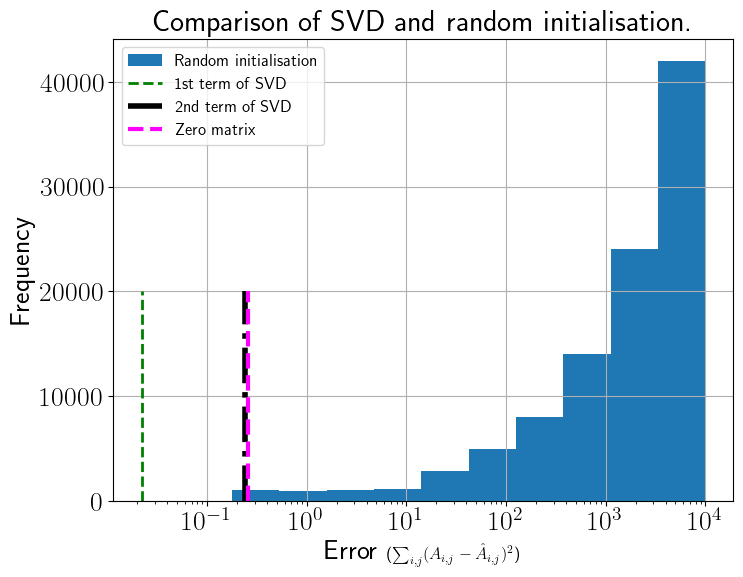

In [10]:
hist, bins, _ = plt.hist(errs, label="Random initialisation")
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.close()

hist, bins, _ = plt.hist(errs, label="Random initialisation", bins=logbins)
plt.vlines(error(approxs[0], A), ymin=0, ymax=20000, color="green", label="1st term of SVD", linestyle="dashed", linewidth=2.0)
plt.vlines(error(approxs[1], A), ymin=0, ymax=20000, color="black", label="2nd term of SVD", linestyle="dashdot", linewidth=4.0)
plt.vlines(error(np.zeros_like(A), A), ymin=0, ymax=20000, color="magenta", label="Zero matrix", linestyle="dashed", linewidth=3.0)



plt.xlabel("Error \large ($\sum_{i,j} (A_{i,j} - \hat{A}_{i,j})^2 $)")
plt.xscale('log')
plt.ylabel("Frequency")
plt.grid()
plt.title("Comparison of SVD and random initialisation.")
plt.legend(loc="upper left")
plt.savefig("svd-results.pdf")
plt.show()
plt.close()